## NSC23
To Do:
1. apa
2. apa

### Library

In [1]:
library(MASS)
library(lmtest)
library(car)
library(tseries)
library(tidyverse)
library(psych)
library(plm)
library(olsrr)
library(tidygeocoder) 
library(sf)
# library(terra) # clash with psych::describe
library(sp)
library(classInt)
library(RColorBrewer)
library(spatialreg)
library(GWmodel)
library(rgdal)
library(corrplot)

library(rgeos)

library(ggExtra) # for awesome plots
library(rgdal)
library(spdep)
library(spgwr)
library(patchwork)

report::report_system()
citation()

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: carData

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::recode() masks car::recode()
✖ dplyr::select() masks MASS::select()
✖ purrr::some()   masks car::some()

Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


The following object is masked from ‘package:car’:

    logit



Attaching package: ‘plm’


The following object

Analyses were conducted using the R Statistical language (version 4.0.5; R Core
Team, 2021) on Ubuntu 20.04.5 LTS


To cite R in publications use:

  R Core Team (2021). R: A language and environment for statistical
  computing. R Foundation for Statistical Computing, Vienna, Austria.
  URL https://www.R-project.org/.

A BibTeX entry for LaTeX users is

  @Manual{,
    title = {R: A Language and Environment for Statistical Computing},
    author = {{R Core Team}},
    organization = {R Foundation for Statistical Computing},
    address = {Vienna, Austria},
    year = {2021},
    url = {https://www.R-project.org/},
  }

We have invested a lot of time and effort in creating R, please cite it
when using it for data analysis. See also ‘citation("pkgname")’ for
citing R packages.


### Read Data

### Read Data
- focus on NTT  
- remove pembentuk IPM: RL1, RL2, PPK, and UHH

In [2]:
# data
dfn = read.csv("/kaggle/input/nsc2022/data_nsc23.csv")
dfn = dfn %>%
  pivot_longer(
    -Kab,
    names_to = c(".value", "tahun"),
    names_pattern = "(...)(..)"
  )

dfn$Kab = toupper(dfn$Kab)
dfn$PDR = dfn$PDR/1000000
dfn$PTP = dfn$PTP/1000

str(dfn)
head(dfn)

# map to viz, path 
path = "/kaggle/input/nsc2022/id_shape/BATAS KABUPATEN KOTA DESEMBER 2019 DUKCAPIL/BATAS KABUPATEN KOTA DESEMBER 2019 DUKCAPIL.shp"
shp1 = st_read(path)


# beware, not all Kab written in the same format 
shpn = shp1[shp1$KAB_KOTA %in% dfn$Kab,]
shpn = cbind(as.data.frame(shpn), as.data.frame(gCentroid(as(shpn, "Spatial"), byid = TRUE)))
shpn = st_as_sf(shpn)

# merge dfn, shpn
shpn1 = merge(dfn, shpn, by.x="Kab", by.y="KAB_KOTA")
shpn1 = st_as_sf(shpn1)

tibble [66 × 8] (S3: tbl_df/tbl/data.frame)
 $ Kab  : chr [1:66] "SUMBA BARAT" "SUMBA BARAT" "SUMBA BARAT" "SUMBA TIMUR" ...
 $ tahun: chr [1:66] "22" "21" "20" "22" ...
 $ PTP  : num [1:66] 18.57 21.22 5.24 31.04 33.36 ...
 $ PDR  : num [1:66] 2.58 2.42 2.35 6.83 6.4 ...
 $ IPM  : num [1:66] 64.4 63.8 63.5 66.2 65.7 ...
 $ IKP  : num [1:66] 68.1 64.6 63.8 69.3 66.2 ...
 $ AHH  : num [1:66] 67.3 67.1 67.1 65.4 65.2 ...
 $ RLS  : num [1:66] 6.85 6.84 6.6 7.33 7.32 7.12 7.41 7.39 7.38 6.76 ...


Kab,tahun,PTP,PDR,IPM,IKP,AHH,RLS
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SUMBA BARAT,22,18.571,2.583328,64.43,68.08,67.35,6.85
SUMBA BARAT,21,21.216,2.416824,63.83,64.63,67.12,6.84
SUMBA BARAT,20,5.242,2.351536,63.53,63.76,67.08,6.60
SUMBA TIMUR,22,31.040,6.825709,66.17,69.30,65.38,7.33
SUMBA TIMUR,21,33.357,6.403410,65.74,66.21,65.16,7.32
SUMBA TIMUR,20,31.354,6.254369,65.52,66.68,65.13,7.12


Reading layer `BATAS KABUPATEN KOTA DESEMBER 2019 DUKCAPIL' from data source 
  `/kaggle/input/nsc2022/id_shape/BATAS KABUPATEN KOTA DESEMBER 2019 DUKCAPIL/BATAS KABUPATEN KOTA DESEMBER 2019 DUKCAPIL.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 515 features and 1 field
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 95.00971 ymin: -11.00762 xmax: 141.0194 ymax: 6.07694
Geodetic CRS:  WGS 84


### Desc Stat (1)

,min,median,mean,max
,<dbl>,<dbl>,<dbl>,<dbl>
PTP,0.71,31.20,59.22,355.34
PDR,1.20,3.85,5.11,26.20
IPM,57.02,64.19,64.43,80.20
IKP,42.74,68.40,67.62,80.24
AHH,60.64,67.07,66.33,70.11
RLS,6.25,7.40,7.61,11.61


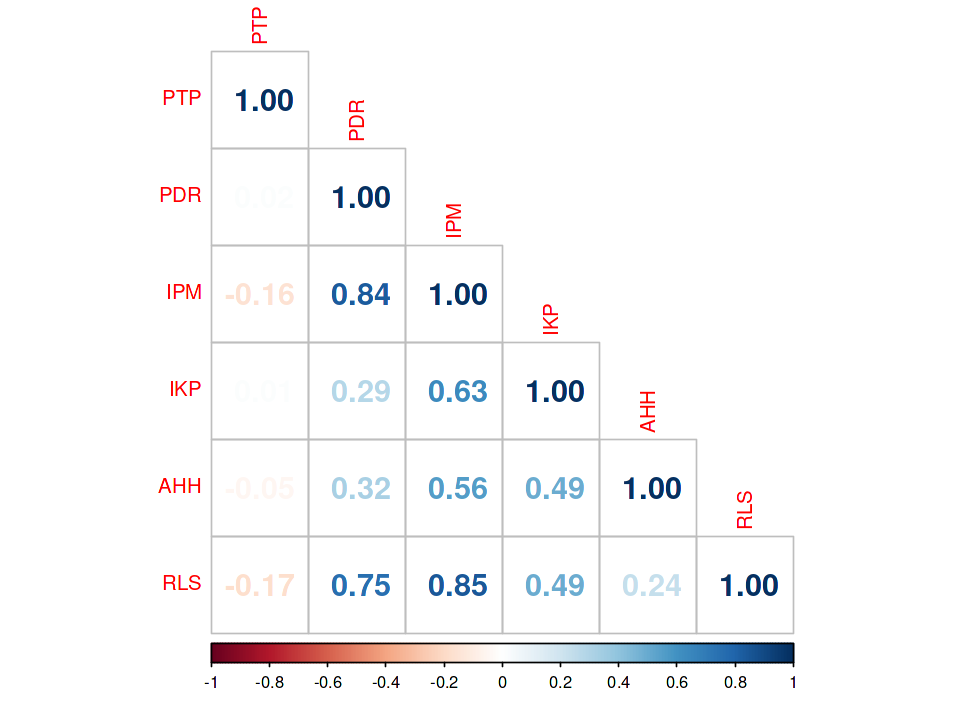

In [3]:
options(repr.plot.width=8, repr.plot.height=6)

des1 = psych::describe(dfn[,-c(1,2)], fast=F)[,c("min", "median", "mean", "max")]
round(des1, 2)

corrplot::corrplot(cor(dfn[,-c(1:2)]), method = "numb", 
                   type="lower", number.cex = 1.5, tl.cex = 1)

### Map
Only to viz, dude. nothing much.   
Klaster PDRB tinggi dan rendah --> hubungan spasial.

Warning message:
“`position_dodge()` requires non-overlapping x intervals”


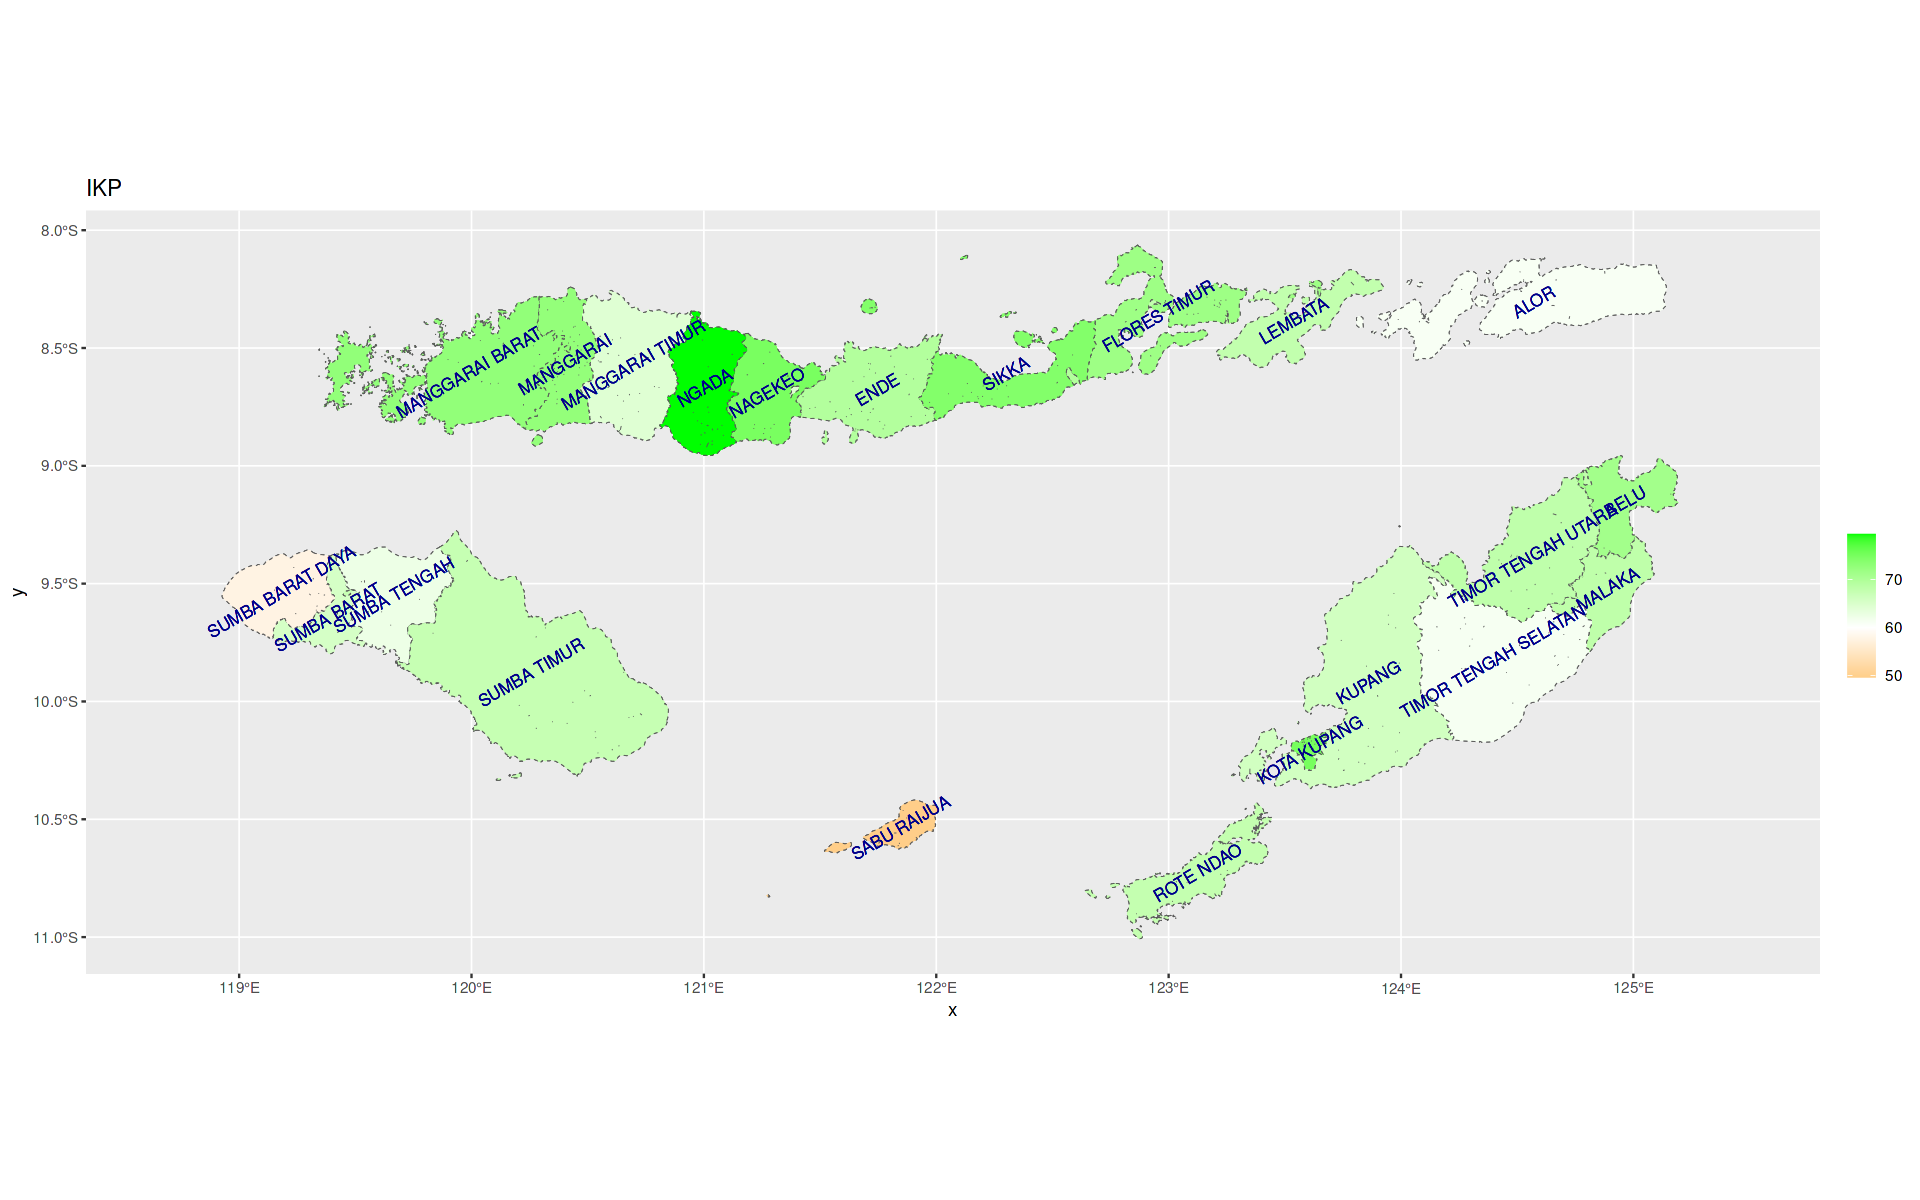

In [4]:
# str(dfn1)

# getting stacked from 19+20+21 
options(repr.plot.width=7, repr.plot.height=5)
pl1 =
ggplot(shpn1, aes(fill = IKP)) +
    geom_sf() +
    geom_text(aes(x=x, y=y, label=Kab), check_overlap=F, angle=30,
              color = 'tomato', fontface = 'bold', size=4, position=position_dodge(1))+
    scale_fill_gradient(high = "green", low = "white", guide="colorbar")


# average
options(repr.plot.width=16, repr.plot.height=10)
shpn1 %>% group_by(Kab) %>% mutate(m=mean(IKP)) %>%
ggplot(aes(fill = m)) +
    geom_sf(linetype=2) +
    geom_text(aes(x=x, y=y, label=Kab), check_overlap=F, angle=30,
              color = 'dark blue', size=3.5, position=position_dodge(1))+
    scale_fill_gradient2(high = "green", mid = "white", low = "orange", guide="colorbar", midpoint=60)+
labs(fill="", title="IKP")



### GWR

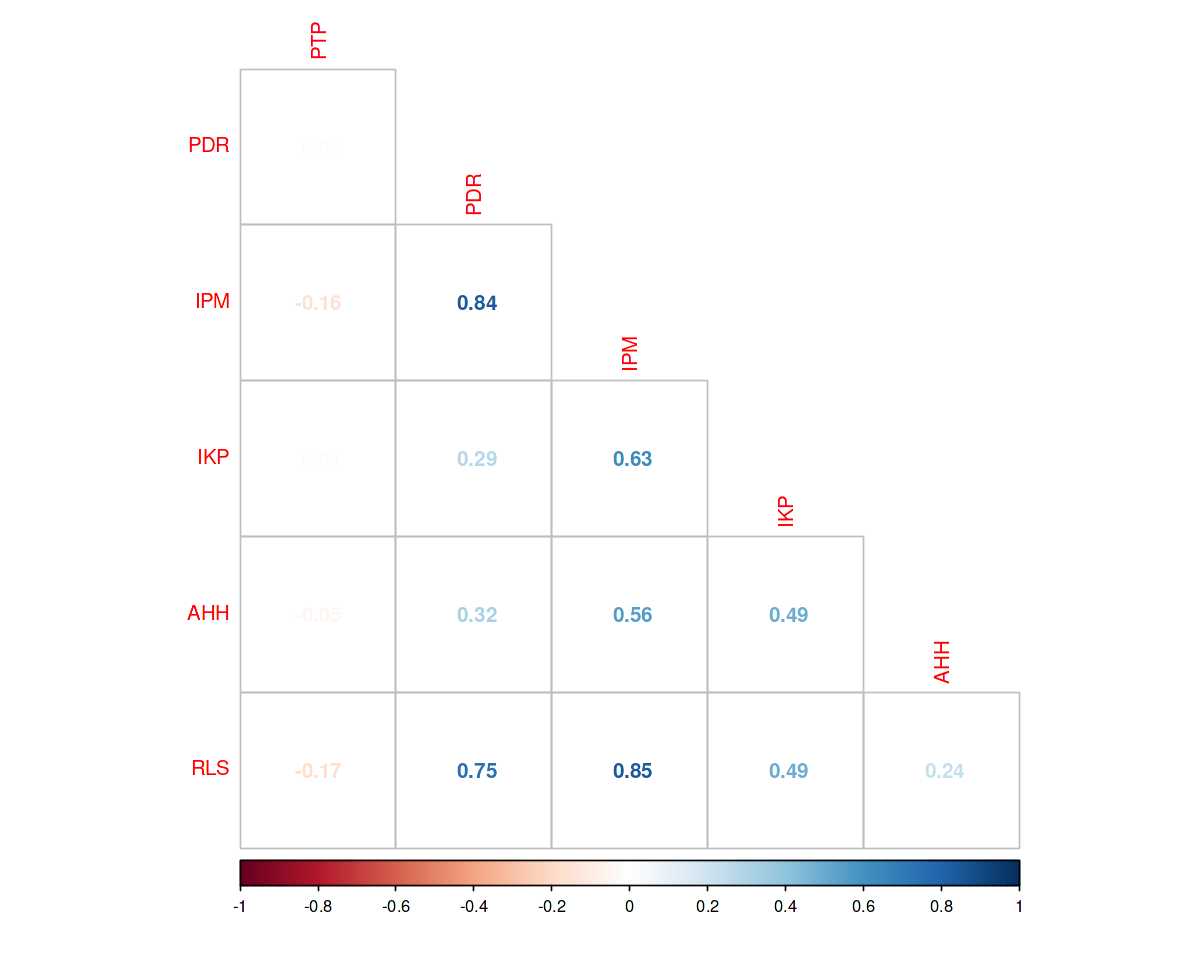

In [5]:
# x is longitude, y is latitude (y is around 0)
dfn1 = as.data.frame(shpn1) %>% select(-geometry)

# kinda useless sih, kan mau dipecah juga.
options(repr.plot.width=10, repr.plot.height=8)
corrplot(cor(dfn1[,-c(1:2, 9:10)]), method = "numb", diag=F, type="lower")

# buat gwr
coordinates(dfn1) = ~x+y


Call:
lm(formula = IKP ~ . - x - y - Kab - tahun, data = dfn1)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.1511  -2.4858  -0.6849   3.1785   8.5125 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -79.487310  17.922393  -4.435 3.99e-05 ***
PTP           0.023624   0.007548   3.130   0.0027 ** 
PDR          -1.330888   0.219098  -6.074 9.23e-08 ***
IPM           2.264840   0.405569   5.584 6.00e-07 ***
AHH           0.052391   0.356857   0.147   0.8838    
RLS           0.407028   1.070816   0.380   0.7052    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.138 on 60 degrees of freedom
Multiple R-squared:  0.6517,	Adjusted R-squared:  0.6227 
F-statistic: 22.46 on 5 and 60 DF,  p-value: 1.284e-12


PTP       PDR       IPM       AHH       RLS 
 1.132973  4.099761 10.683295  2.214847  4.938102


Call:
lm(formula = IKP ~ . - x - y - Kab - tahun - AHH, data = dfn1)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.2450  -2.4595  -0.7293   3.1937   8.5391 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -78.062965  14.948109  -5.222 2.26e-06 ***
PTP           0.023728   0.007454   3.183  0.00229 ** 
PDR          -1.340424   0.207563  -6.458 1.96e-08 ***
IPM           2.306705   0.286074   8.063 3.42e-11 ***
RLS           0.327619   0.916729   0.357  0.72204    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.104 on 61 degrees of freedom
Multiple R-squared:  0.6516,	Adjusted R-squared:  0.6288 
F-statistic: 28.52 on 4 and 61 DF,  p-value: 2.254e-13


PTP      PDR      IPM      RLS 
1.122839 3.739420 5.402006 3.678201


Call:
lm(formula = IKP ~ . - x - y - Kab - tahun - -AHH - RLS, data = dfn1)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.1395  -2.3215  -0.8061   3.3033   8.5720 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -78.785159  17.701492  -4.451 3.70e-05 ***
PTP           0.023451   0.007482   3.135  0.00265 ** 
PDR          -1.330695   0.217556  -6.117 7.44e-08 ***
IPM           2.372684   0.287772   8.245 1.67e-11 ***
AHH          -0.016125   0.305820  -0.053  0.95812    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.109 on 61 degrees of freedom
Multiple R-squared:  0.6509,	Adjusted R-squared:  0.628 
F-statistic: 28.43 on 4 and 61 DF,  p-value: 2.396e-13


PTP      PDR      IPM      AHH 
1.128883 4.099739 5.455158 1.649754

IKP ~ PTP + PDR + IPM + AHH


	studentized Breusch-Pagan test

data:  nm1a
BP = 14.466, df = 4, p-value = 0.005948


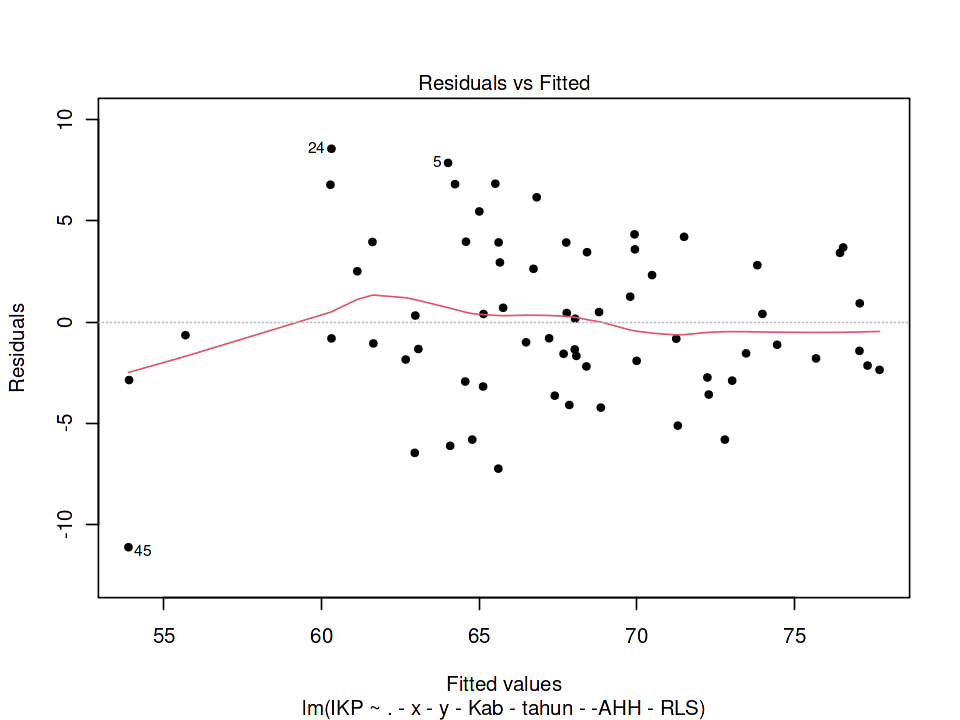

In [6]:
options(repr.plot.width=8, repr.plot.height=6)

# check VIF, alls good
nm1a = lm(IKP~.-x-y-Kab-tahun, dfn1)
summary(nm1a)
vif(nm1a)

nm1a = lm(IKP~.-x-y-Kab-tahun-AHH, dfn1)
summary(nm1a)
vif(nm1a)

nm1a = lm(IKP~.-x-y-Kab-tahun--AHH-RLS, dfn1)
summary(nm1a)
vif(nm1a)


formula(update(nm1a, .~.))

# check BP. not bad? assume it is.
bptest(nm1a)
plot(nm1a, pch=20, which=1)


In [7]:
# copas formula here. choose bandwidth? yeah.
for (j in c("bisquare", "gaussian", "exponential")){
    bwd1 = bw.gwr(IKP ~ PTP + PDR + IPM, dfn1, 
                  approach="cv", kernel=j, adaptive=T)

    mod1 = gwr.basic(IKP ~ PTP + PDR + IPM, dfn1, 
                  bw = bwd1, kernel=j, adaptive=T)
     
    print(j)
    print(mod1$GW.diagnostic$AIC)
    print(mod1$GW.diagnostic$gw.R2)   
}


Adaptive bandwidth: 48 CV score: 844.9827 
Adaptive bandwidth: 38 CV score: 791.9994 
Adaptive bandwidth: 30 CV score: 614.8622 
Adaptive bandwidth: 27 CV score: 569.9971 
Adaptive bandwidth: 23 CV score: 544.6416 
Adaptive bandwidth: 22 CV score: 544.6416 
[1] "bisquare"
[1] 305.3828
[1] 0.8977928
Adaptive bandwidth: 48 CV score: 1034.171 
Adaptive bandwidth: 38 CV score: 999.3461 
Adaptive bandwidth: 30 CV score: 926.822 
Adaptive bandwidth: 27 CV score: 891.6423 
Adaptive bandwidth: 23 CV score: 858.8594 
Adaptive bandwidth: 22 CV score: 858.8594 
[1] "gaussian"
[1] 350.3555
[1] 0.7635324
Adaptive bandwidth: 48 CV score: 941.28 
Adaptive bandwidth: 38 CV score: 905.9445 
Adaptive bandwidth: 30 CV score: 838.4061 
Adaptive bandwidth: 27 CV score: 810.9794 
Adaptive bandwidth: 23 CV score: 780.7178 
Adaptive bandwidth: 22 CV score: 780.7178 
[1] "exponential"
[1] 342.3442
[1] 0.7939695


In [8]:
bwd1a = bw.gwr(IKP ~ PTP + PDR + IPM, dfn1, 
                  approach="cv", kernel="bisquare", adaptive=T)
mod1a = gwr.basic(IKP ~ PTP + PDR + IPM, dfn1, 
                  bw = bwd1a, kernel="bisquare", adaptive=T)
mod1a


umm1a1 = as.data.frame(mod1a$SDF)[,c(1:4,ncol(mod1a$SDF))]
round(psych::describe(unique(umm1a1))[,c(2,3,5,8,9)], 3)

umm1a2 = as.data.frame(mod1a$SDF)[,1:4]*(gwr.t.adjust(mod1a)$results$p < 0.05)
is.na(umm1a2) = umm1a2 == 0
round(psych::describe(unique(umm1a2))[,c(2,3,5,8,9)], 5)

Adaptive bandwidth: 48 CV score: 844.9827 
Adaptive bandwidth: 38 CV score: 791.9994 
Adaptive bandwidth: 30 CV score: 614.8622 
Adaptive bandwidth: 27 CV score: 569.9971 
Adaptive bandwidth: 23 CV score: 544.6416 
Adaptive bandwidth: 22 CV score: 544.6416 


   ***********************************************************************
   *                       Package   GWmodel                             *
   ***********************************************************************
   Program starts at: 2023-07-15 06:37:32 
   Call:
   gwr.basic(formula = IKP ~ PTP + PDR + IPM, data = dfn1, bw = bwd1a, 
    kernel = "bisquare", adaptive = T)

   Dependent (y) variable:  IKP
   Independent variables:  PTP PDR IPM
   Number of data points: 66
   ***********************************************************************
   *                    Results of Global Regression                     *
   ***********************************************************************

   Call:
    lm(formula = formula, data = data)

   Residuals:
    Min      1Q  Median      3Q     Max 
-11.100  -2.314  -0.805   3.302   8.566 

   Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
   (Intercept) -79.317088  14.427781  -5.498 7.72e-07 ***
   PTP

,n,mean,median,min,max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,23,-66.243,-58.646,-181.788,49.736
PTP,23,0.007,0.006,-0.028,0.035
PDR,23,-0.949,-1.123,-2.283,1.406
IPM,23,2.163,2.110,0.256,3.956
Local_R2,23,0.831,0.917,0.491,0.953


,n,mean,median,min,max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,12,-114.11848,-95.69747,-181.78832,-58.64551
PTP,5,0.02504,0.02383,0.01830,0.03545
PDR,15,-1.22626,-1.62060,-2.28337,1.40564
IPM,19,2.41478,2.17941,1.01160,3.95645


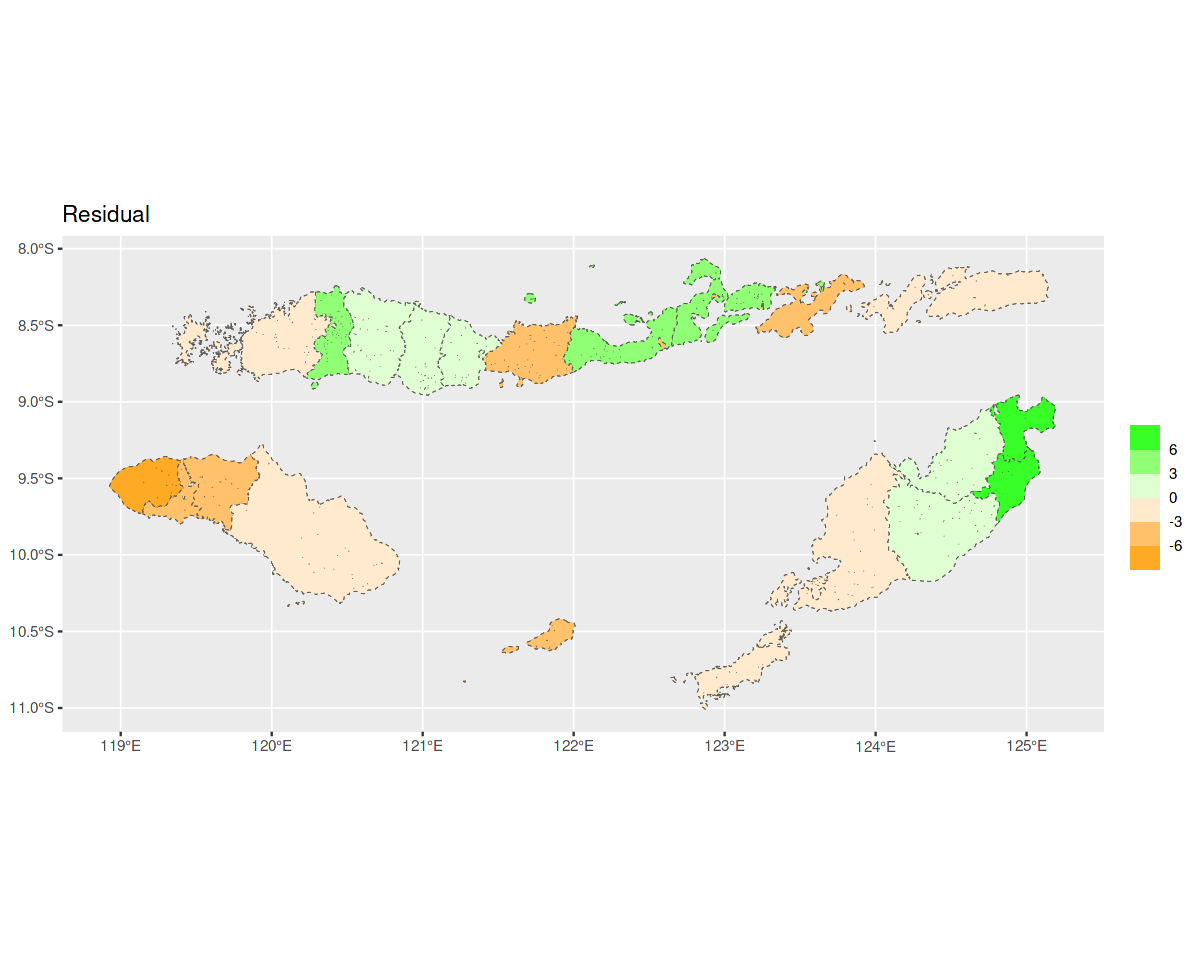

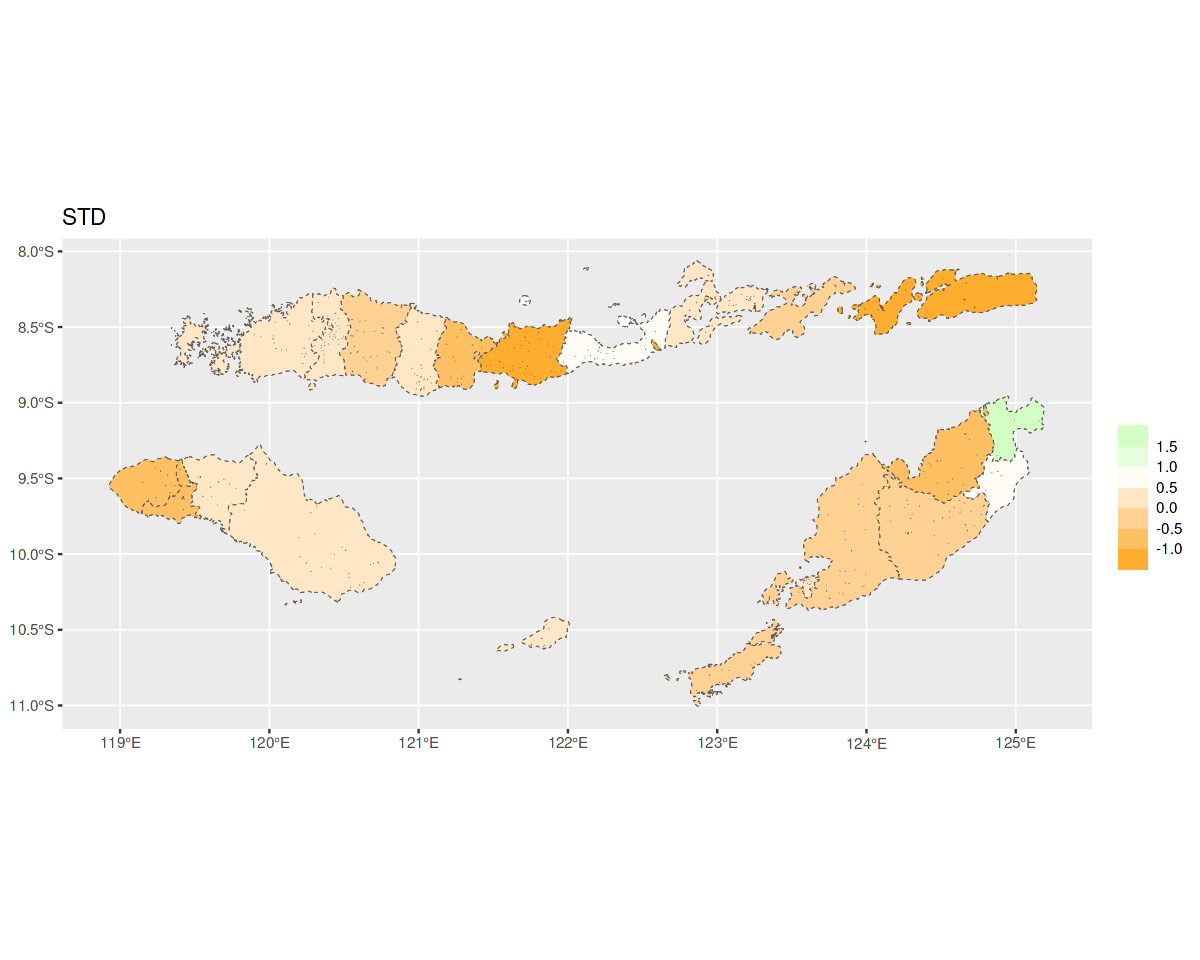

In [9]:
options(repr.plot.width=10, repr.plot.height=8)
shpn2 = shpn1
shpn2$resid = nm1a$resid
shpn2$std = mod1a$SDF$Stud_residual

my.palette <- brewer.pal(n = 4, name = "YlGn") 

shpn2 %>% group_by(Kab) %>% mutate(m=mean(resid)) %>%
ggplot(aes(fill = m)) +
    geom_sf(linetype=2) +
#     geom_text(aes(x=x, y=y, label=Kab), check_overlap=F, angle=30,
#               color = 'dark blue', size=3.5, position=position_dodge(1))+
    scale_fill_steps2(high = "green", mid = "white", low="orange", guide="colorsteps", n.breaks=5)+
    labs(title="Residual", fill="")

shpn2 %>% group_by(Kab) %>% mutate(m=mean(std)) %>%
ggplot(aes(fill = m)) +
    geom_sf(linetype=2) +
#     geom_text(aes(x=x, y=y, label=Kab), check_overlap=F, angle=30,
#               color = 'dark blue', size=3.5, position=position_dodge(1))+
    scale_fill_steps2(high = "green", mid = "white", low="orange", guide="colorsteps", midpoint=0.85, n.breaks=7)+
    labs(title="STD", fill="")
#     scale_fill_stepsn(colors=my.palette)
#     scale_fill_stepsn(colours = terrain.colors(3))

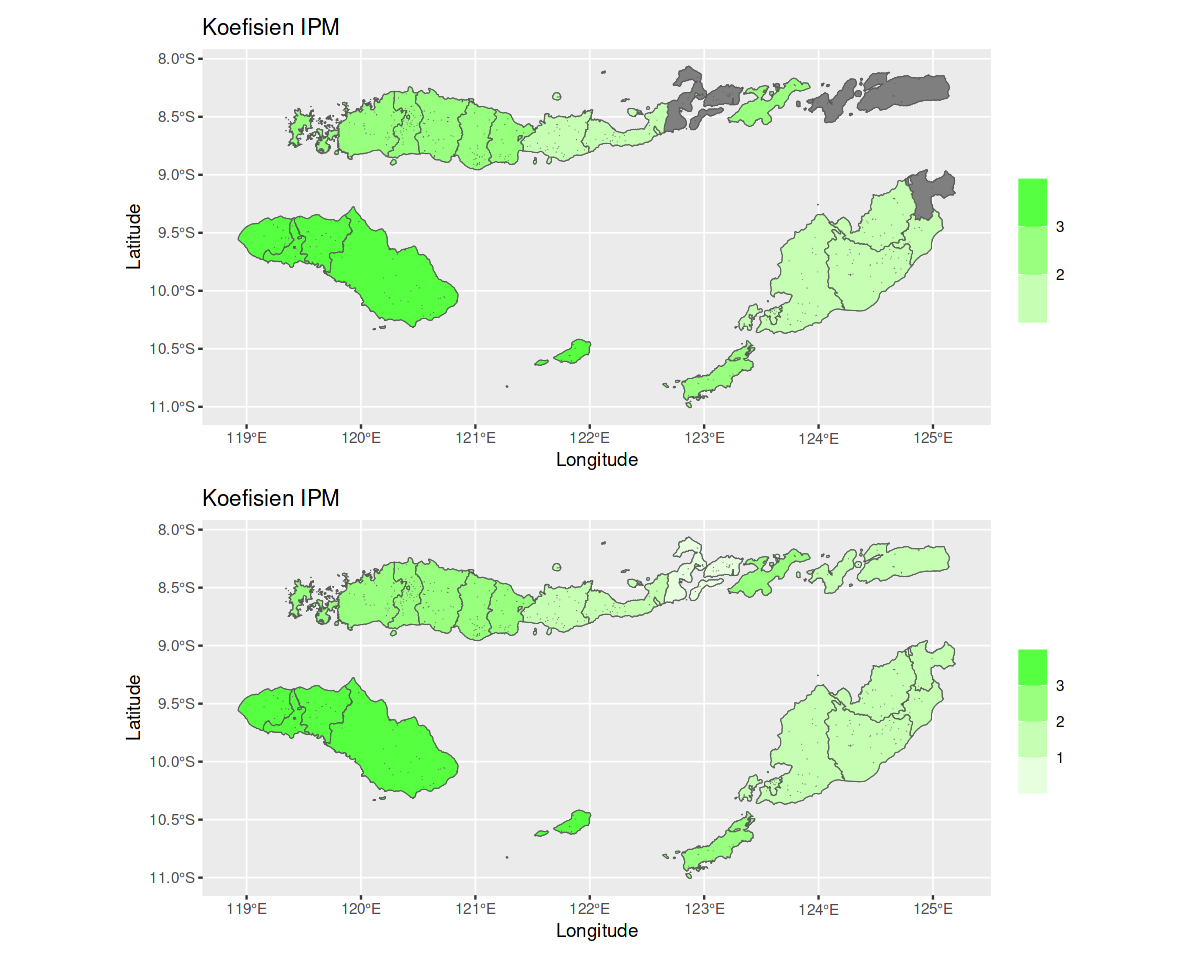

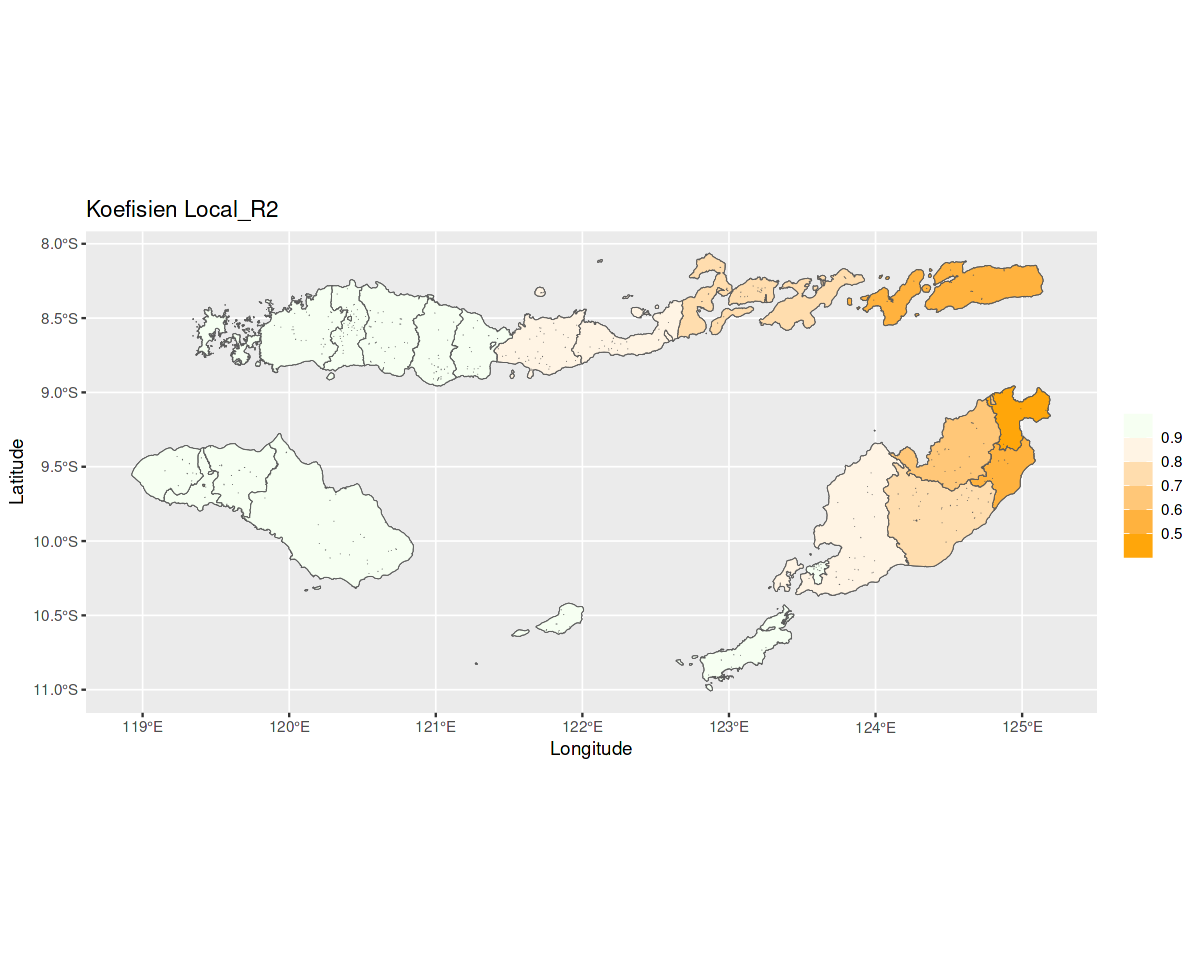

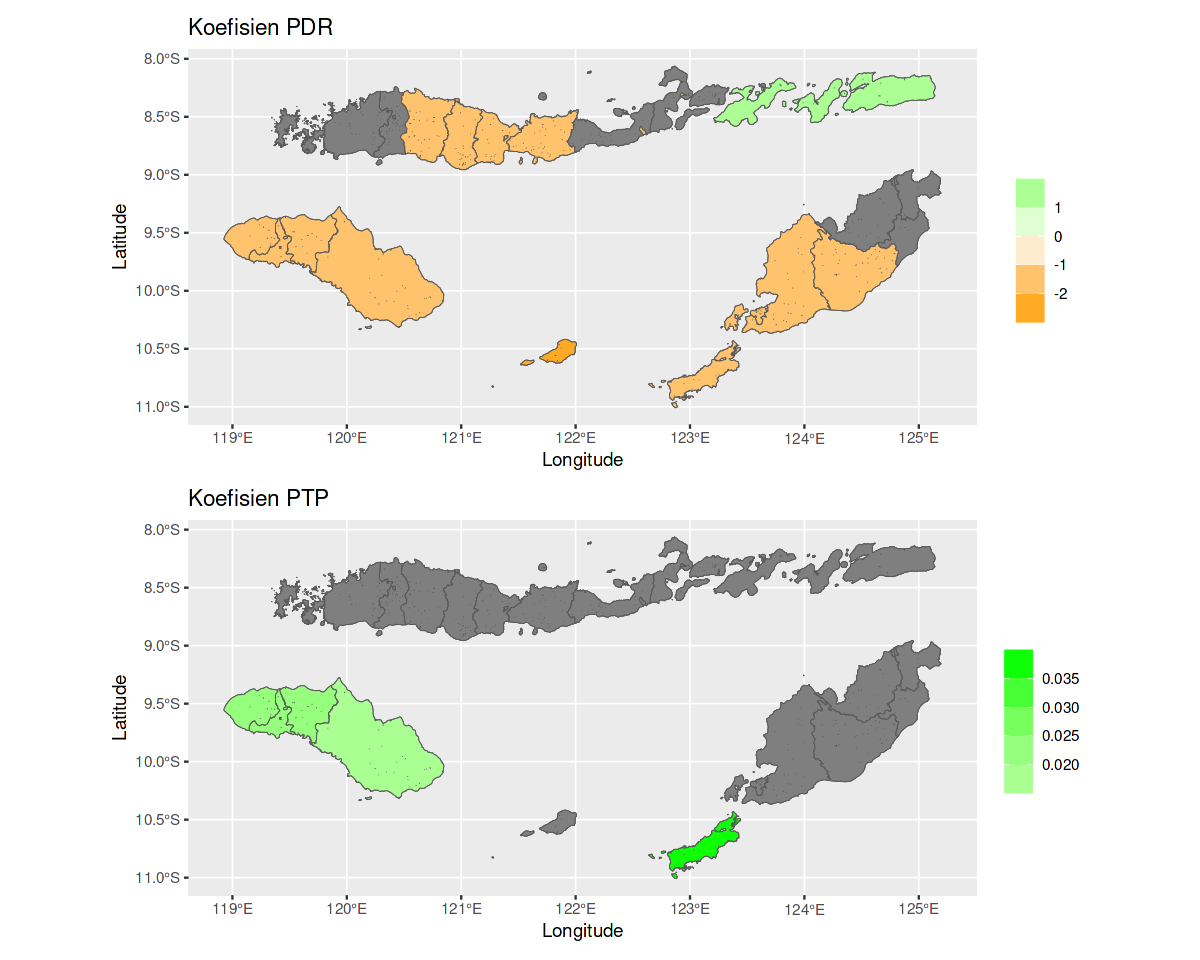

In [10]:
# merge shp1 and unique koefisien per wilayah.
fmap = function(ex = "IPM", data = umm1a2, mids = 0, shape=shpn1){
    options(repr.plot.width=10, repr.plot.height=8)
    
    ggplot(shpn1$geometry) +
    geom_sf(aes(fill=data[,ex])) +
#     geom_text(aes(x=x, y=y, label=Kab), check_overlap=F, angle=30,
#               color = 'dark blue', size=3.5, position=position_dodge(1))+
    scale_fill_steps2(high = "green", mid="white", low = "orange", guide="colorbar", midpoint=mids)+
    labs(title=paste("Koefisien", ex), fill="", x="Longitude", y="Latitude")
}

# signif only, ALL, R2
fmap("IPM")/fmap("IPM", umm1a1)
fmap("Local_R2", umm1a1, 0.9)

fmap("PDR")/fmap("PTP"); 


### PANEL


In [11]:
# summary(nm1a)
# formula(update(nm1a, .~.))

In [12]:
# # modelling ALL.
# nc1 = plm(IKP ~ PTP + PDR + IPM + AHH + RLS,
#           dfn1, model="pooling", index=c("Kab", "tahun"))
# nf1 = update(nc1, .~., model="within")
# nr1 = update(nc1, .~., model="random")

# summary(nc1); summary(nf1); summary(nr1)

In [13]:
# # individual, time or two ways -> id
# plmtest(nc1,"two", type="bp")
# plmtest(nc1,"ind", type="bp")
# plmtest(nc1,"time", type="bp")


# # random or fixed effect -> fe or using pool?
# pooltest(nc1, nf1) #chow juga? h1: fixed
# pFtest(nf1, nc1) #chow, h1: fixed
# phtest(nf1, nr1) #hausman, h1: fixed

# # cross sectional dependence
# pcdtest(nr1)

# # get gf1, diagnostic, all bad, using arrelano, using pwartest for small T
# pbgtest(nr1, order=1)
# bptest(nr1)


In [14]:
# pbgtest(nr1)
# bptest(nr1)
# coeftest(nr1, vcovHC(nr1, method="white1")) 

# nr2 = update(nr1, .~.-AHH)
# pbgtest(nr2)
# bptest(nr2)
# coeftest(nr2, vcovHC(nr2, method="white1")) 

# nr3 = update(nr2, .~.-RLS)
# pbgtest(nr3)
# bptest(nr3)
# coeftest(nr3, vcovHC(nr3, method="white1")) 



In [15]:
# fmodels = list(nr1, nr2, nr3)
# for (j in 1:3){
#     i = summary(fmodels[[j]])
#     print(paste("nf", j))
#     sse = sum(resid(i)^2)
#     names(sse) = "sse"
#     print(c(i$r.squared, sse))
# }